In [1]:
import tensorflow as tf
tf.enable_eager_execution()

Load Data with From Training and Validation 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'idfy_generated_data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'idfy_generated_data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        
        batch_size=1,
        class_mode='categorical')

Found 1477 images belonging to 36 classes.
Found 518 images belonging to 36 classes.


CNN MODEL

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)  

In [5]:
#history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20, batch_size=64)
batch_size=1
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 10, callbacks=None)

Epoch 1/10
Instructions for updating:
Use tf.cast instead.
1477/1477 [==============================] - 123s 84ms/step - loss: 1.4116 - acc: 0.6188 - val_loss: 0.3700 - val_acc: 0.9073
Epoch 2/10
1477/1477 [==============================] - 122s 83ms/step - loss: 0.4619 - acc: 0.8930 - val_loss: 0.2207 - val_acc: 0.9537
Epoch 3/10
1477/1477 [==============================] - 126s 85ms/step - loss: 0.3238 - acc: 0.9303 - val_loss: 0.1450 - val_acc: 0.9556
Epoch 4/10
1477/1477 [==============================] - 123s 83ms/step - loss: 0.2377 - acc: 0.9397 - val_loss: 0.1176 - val_acc: 0.9768
Epoch 5/10
1477/1477 [==============================] - 115s 78ms/step - loss: 0.2206 - acc: 0.9513 - val_loss: 0.1019 - val_acc: 0.9826
Epoch 6/10
1477/1477 [==============================] - 113s 76ms/step - loss: 0.2088 - acc: 0.9546 - val_loss: 0.1398 - val_acc: 0.9749
Epoch 7/10
1477/1477 [==============================] - 104s 71ms/step - loss: 0.2110 - acc: 0.9506 - val_loss: 0.1432 - val_acc: 

In [10]:
model.save_weights('idfy_train_val_model_weights.h5')

# Save the model architecture
with open('idfy_train_val_model.json', 'w') as f:
    f.write(model.to_json())

Now Lets See How model Works on Testing Data 

In [22]:
import pandas as pd
from PIL import Image
import os   
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc

In [23]:
test_df = pd.read_csv("test_df_idfy.csv")

In [24]:
test_df.head(5)

,Unnamed: 0,track_id,image_path,lp,train
0,525,./crop_m4/I00023.png,./crop_h4/I00023.png,7B27150,0
1,39,./crop_m1/I00019.png,./crop_h1/I00019.png,5B28893,0
2,550,./crop_m4/I00036.png,./crop_m4/I00036.png,1BD4657,0
3,102,./crop_m2/I00031.png,./crop_m2/I00031.png,2SE8601,0
4,49,./crop_m2/I00004.png,./crop_h2/I00004.png,4B50811,0


In [49]:
test_df.shape

(131, 6)

In [25]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    return plate_number

In [26]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [27]:
def segment_characters(image,default_resize=310) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (default_resize, 90))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [28]:
def predict_results(df):
    image_path = df["image_path"]
    image_path_str = image_path.split("/")[-1]
    image_path_str = image_path_str.split(".")[0]
    number = str(df["lp"])
    number_list = list(number)
    image_path = image_path.replace("./","2017-IWT4S-HDR_LP-dataset/")
    image = cv2.imread(image_path)
    char_list = segment_characters(image)
    if len(char_list) > 7 or len(char_list) < 7:
        print("i am not saving")
        char_list = segment_characters(image,340)
        if len(char_list) > 7 or len(char_list) < 7:
            return "Distorted_image"
        else:
            return show_results(char_list)
    else:
        return show_results(char_list)
            

Removing All the Distorted Images Which Got failed to make Contours from 

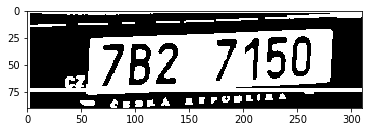

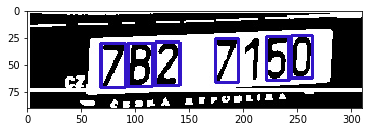

i am not saving


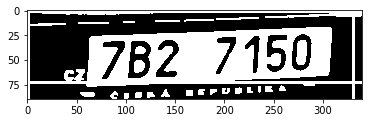

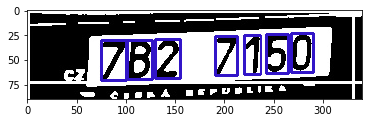

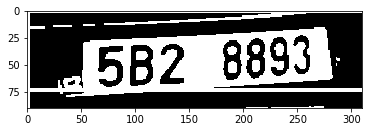

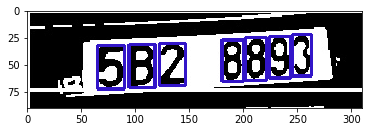

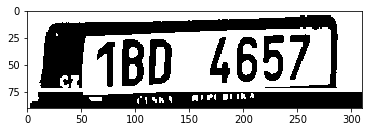

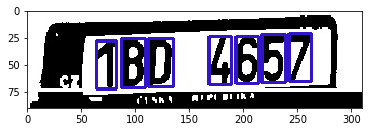

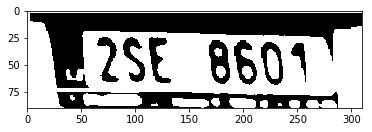

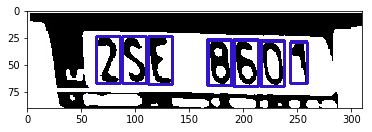

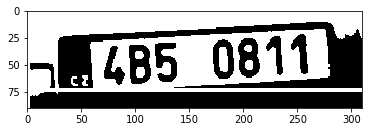

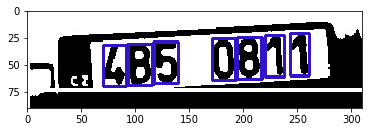

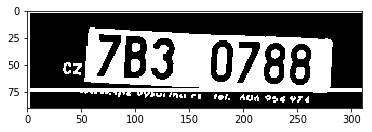

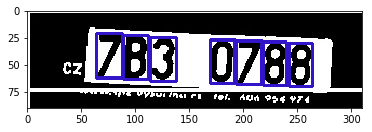

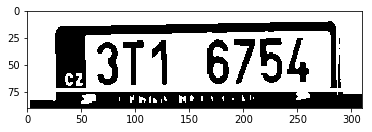

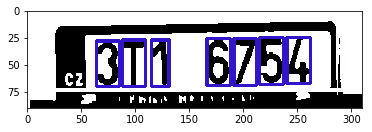

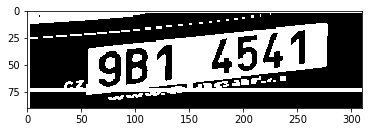

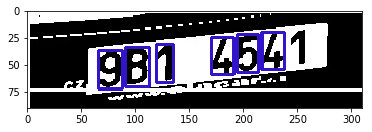

i am not saving


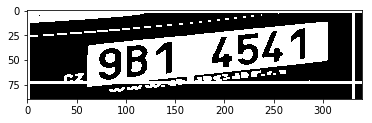

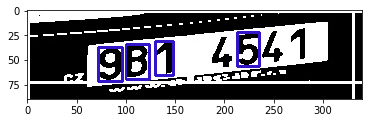

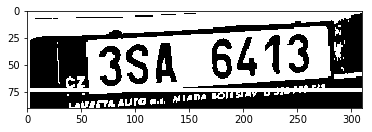

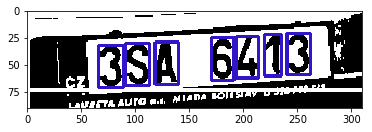

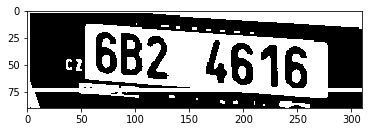

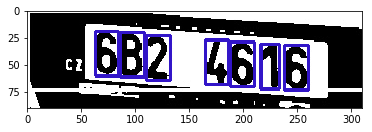

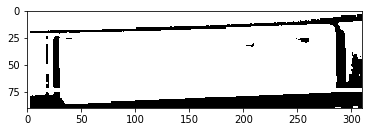

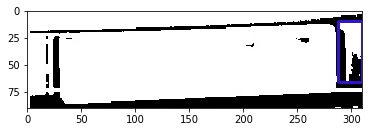

i am not saving


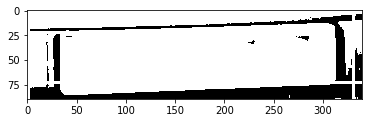

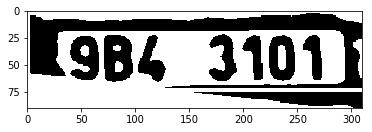

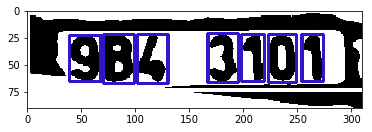

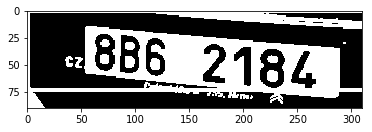

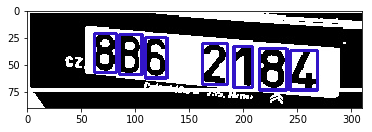

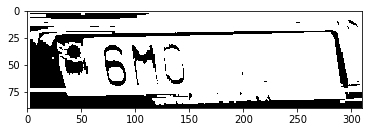

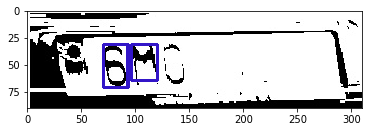

i am not saving


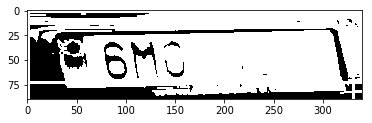

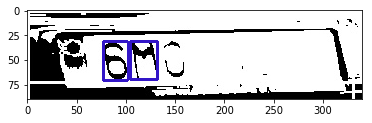

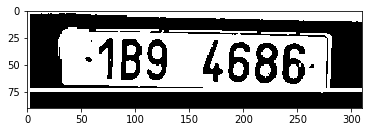

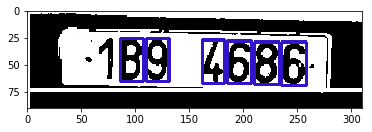

i am not saving


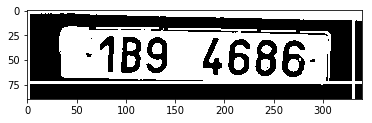

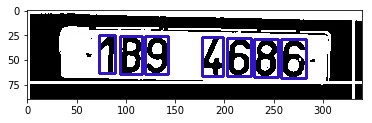

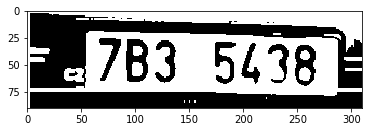

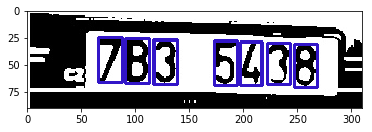

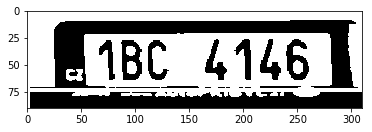

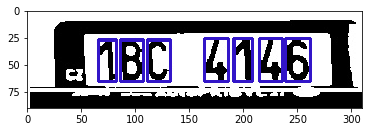

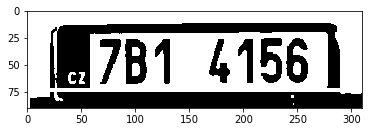

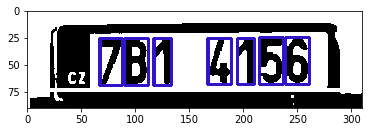

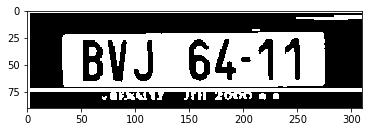

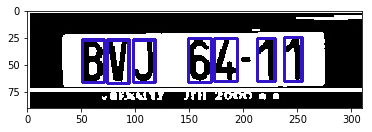

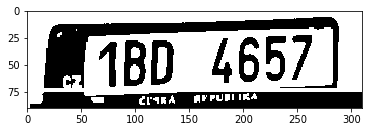

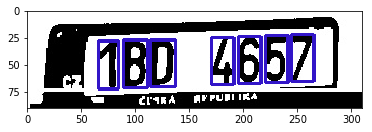

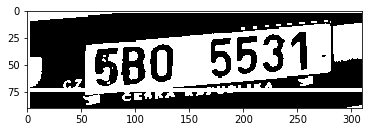

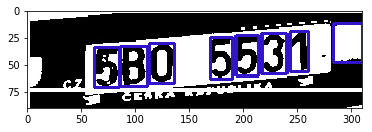

i am not saving


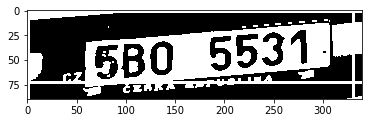

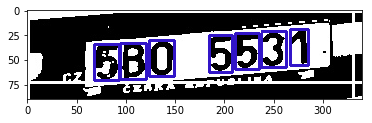

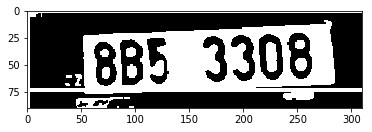

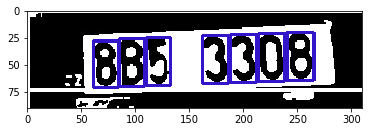

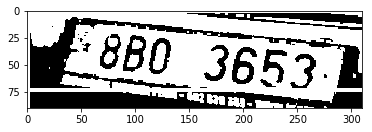

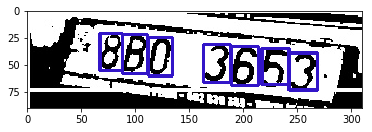

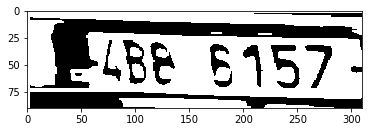

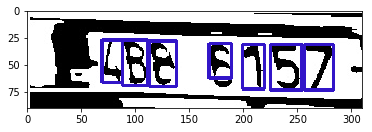

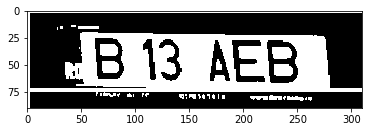

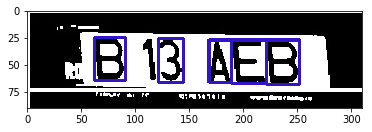

i am not saving


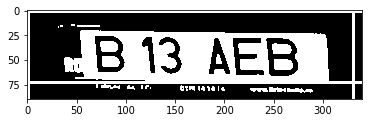

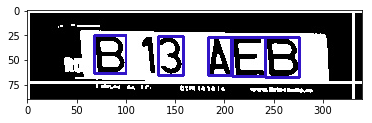

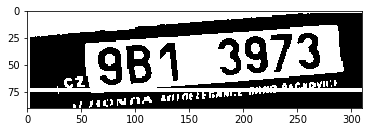

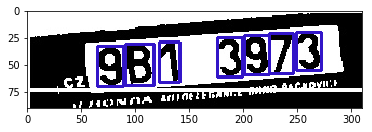

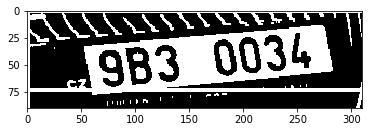

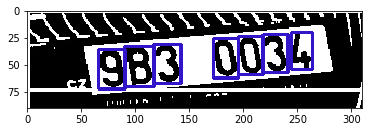

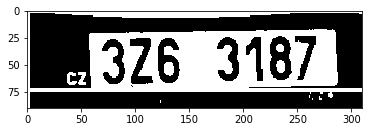

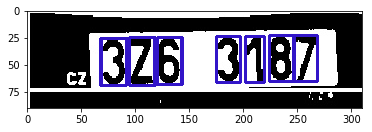

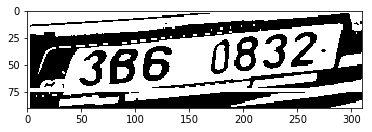

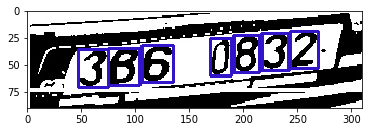

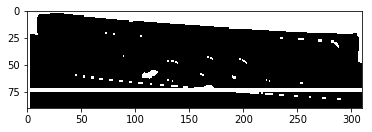

i am not saving


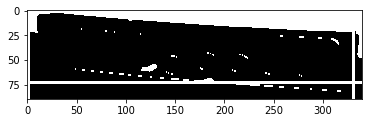

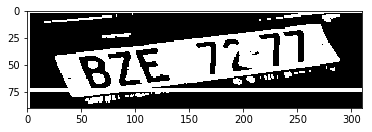

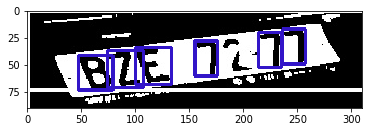

i am not saving


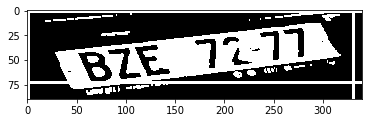

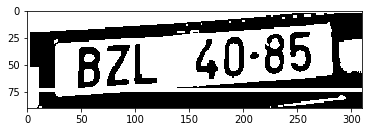

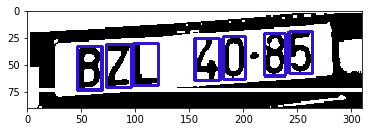

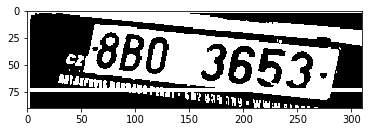

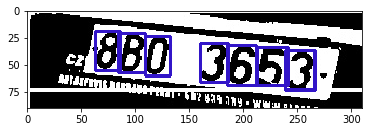

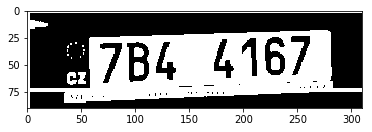

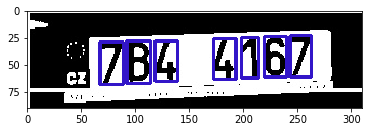

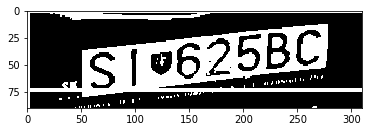

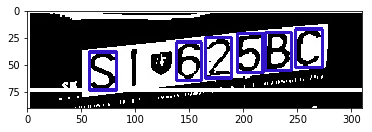

i am not saving


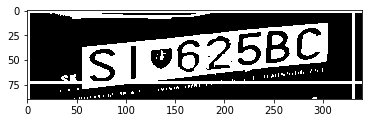

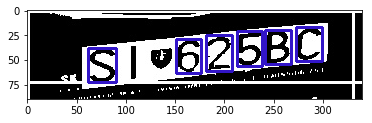

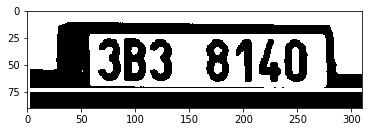

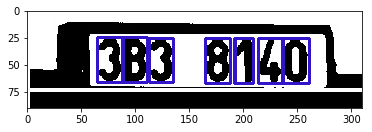

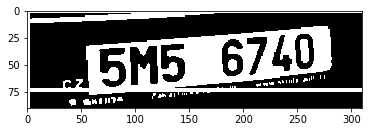

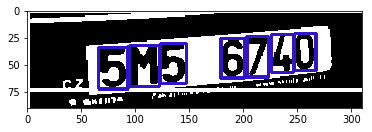

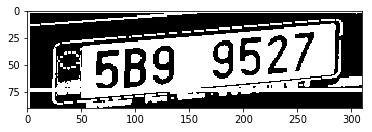

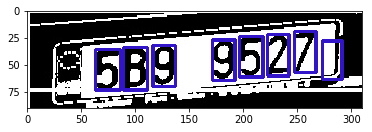

i am not saving


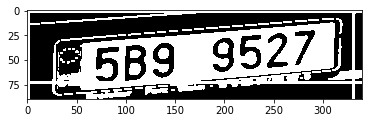

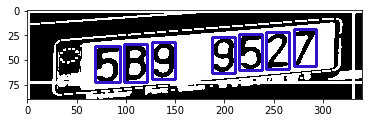

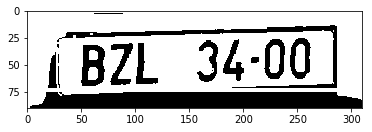

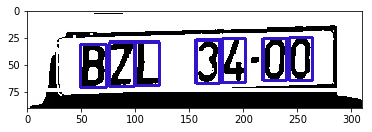

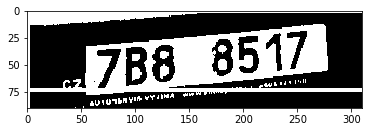

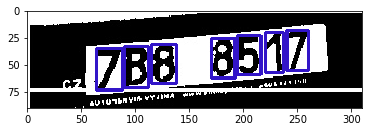

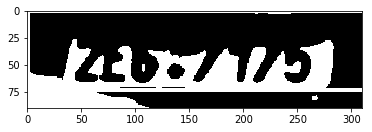

i am not saving


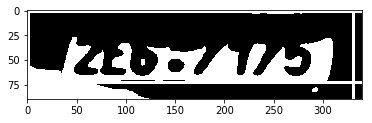

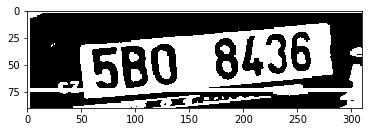

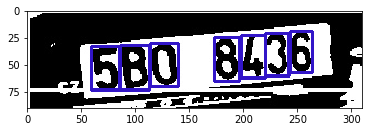

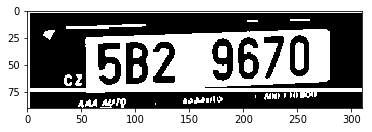

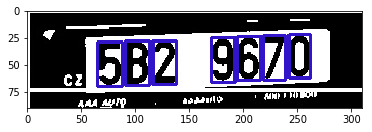

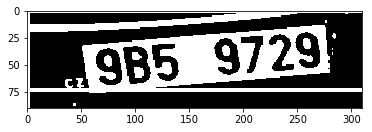

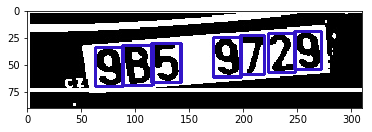

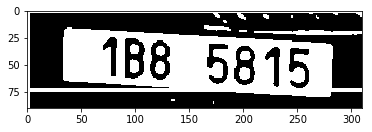

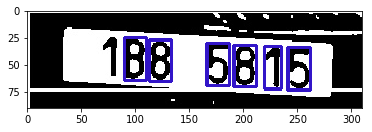

i am not saving


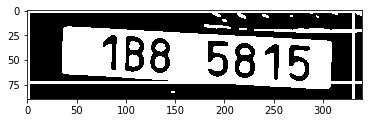

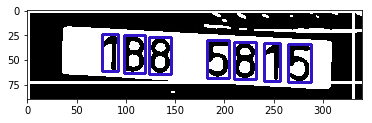

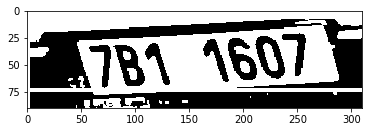

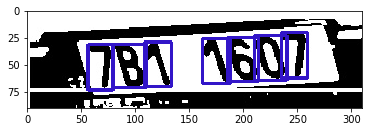

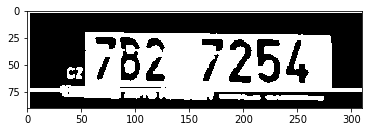

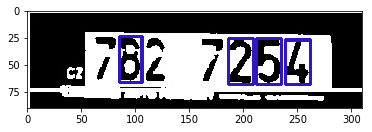

i am not saving


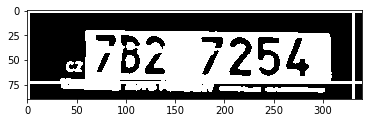

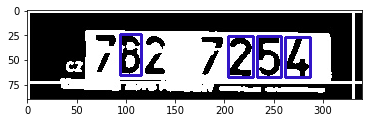

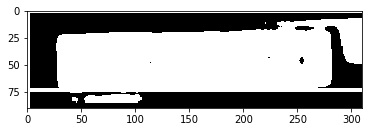

i am not saving


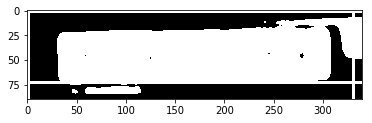

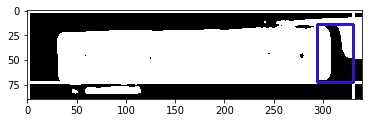

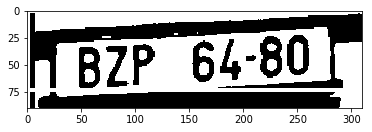

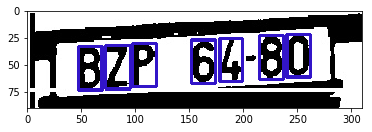

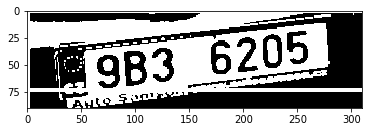

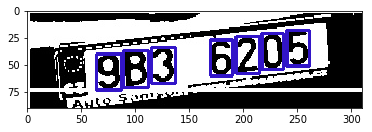

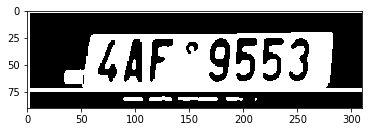

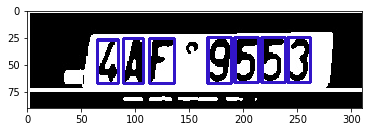

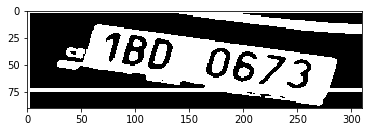

i am not saving


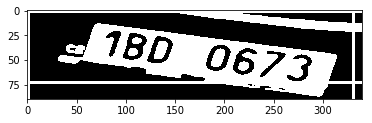

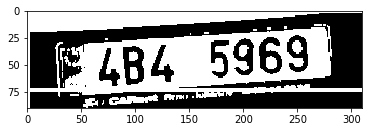

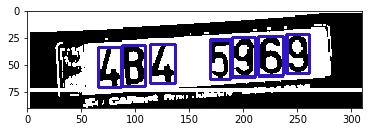

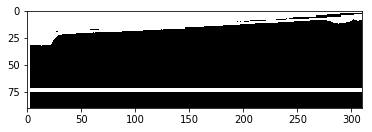

i am not saving


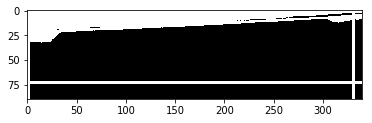

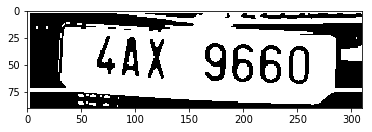

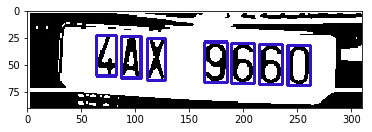

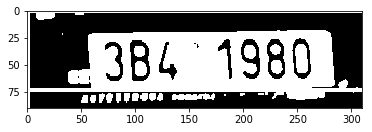

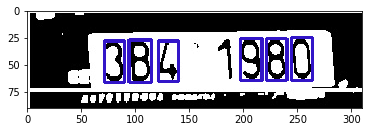

i am not saving


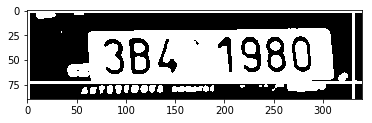

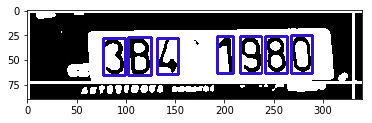

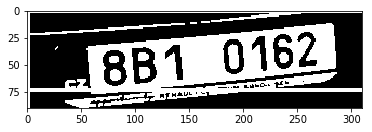

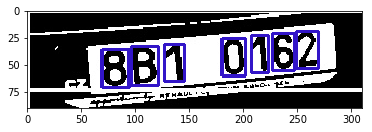

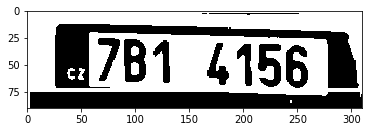

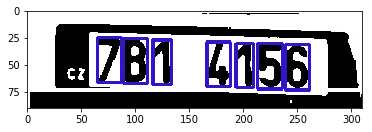

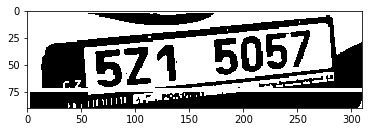

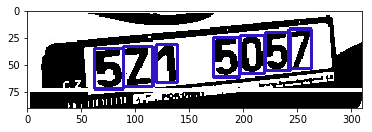

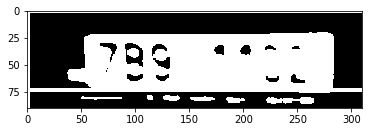

i am not saving


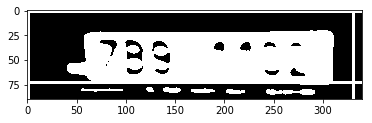

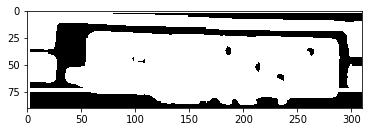

i am not saving


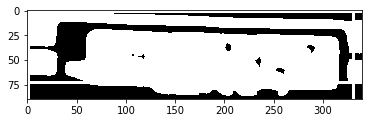

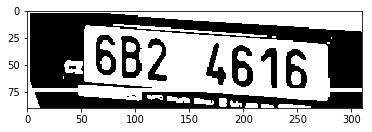

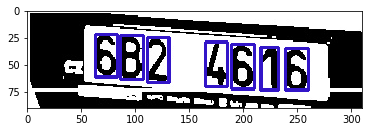

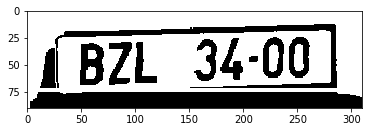

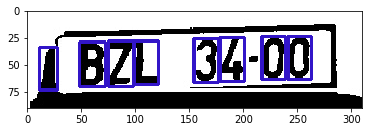

i am not saving


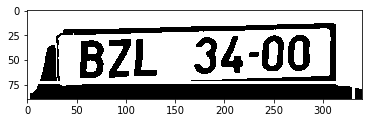

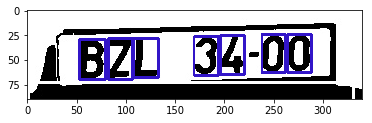

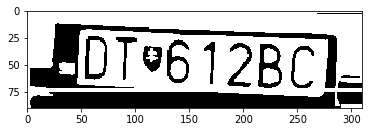

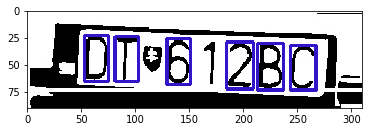

i am not saving


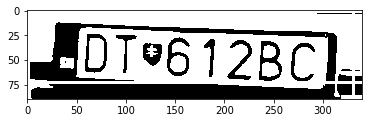

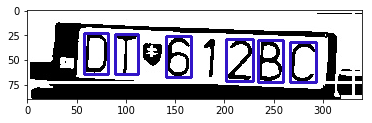

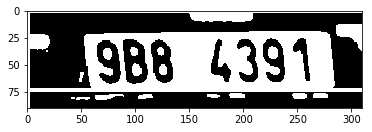

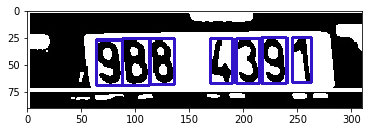

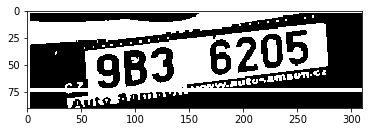

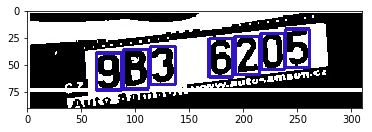

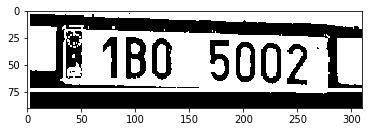

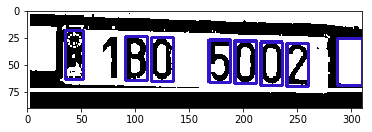

i am not saving


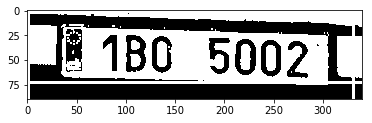

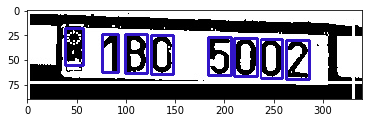

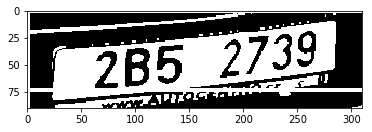

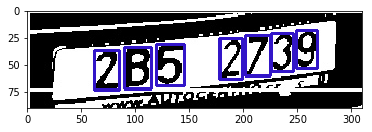

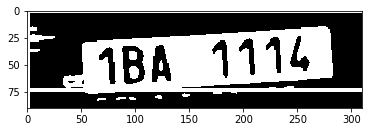

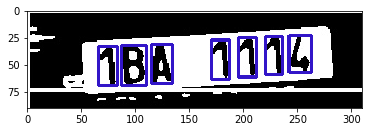

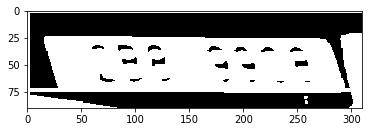

i am not saving


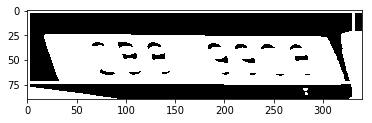

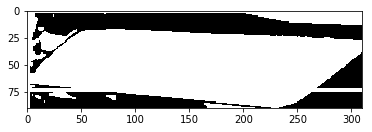

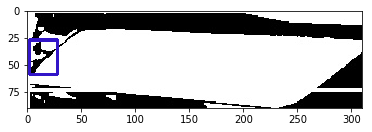

i am not saving


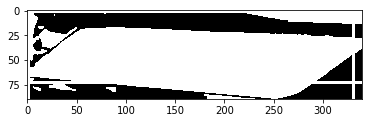

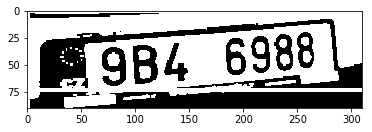

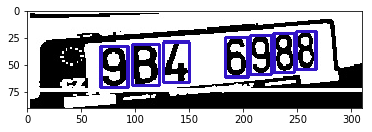

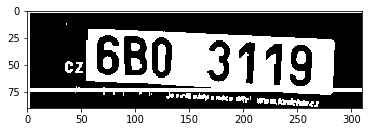

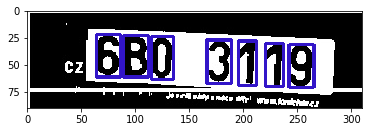

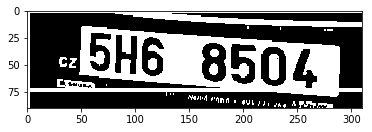

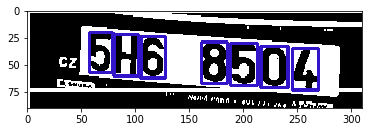

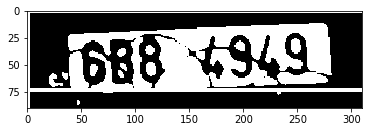

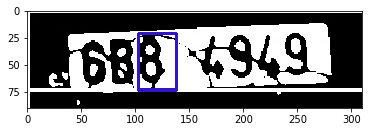

i am not saving


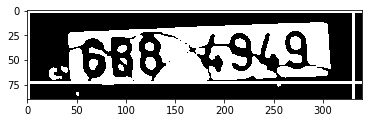

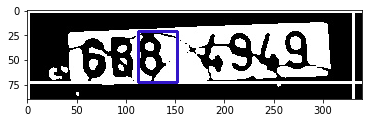

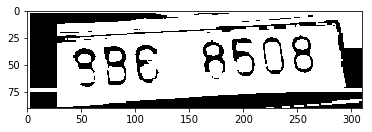

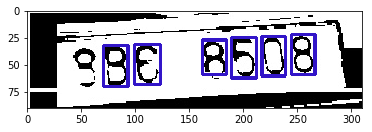

i am not saving


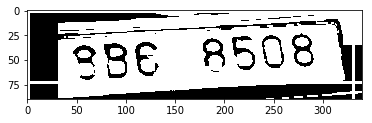

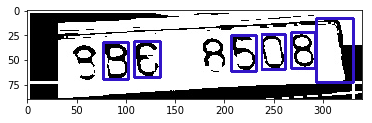

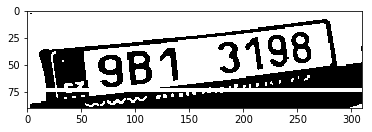

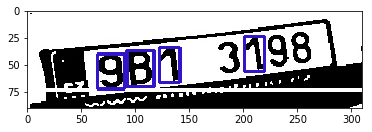

i am not saving


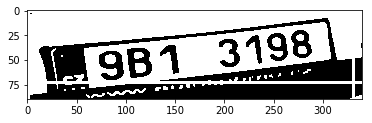

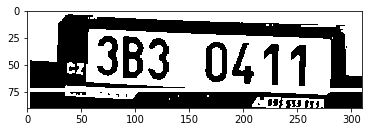

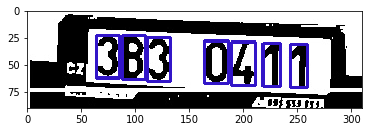

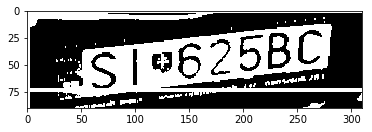

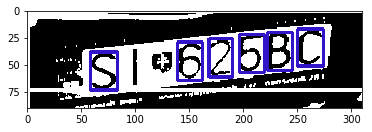

i am not saving


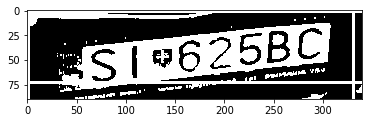

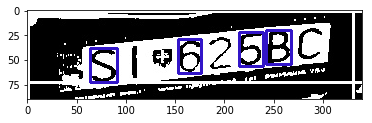

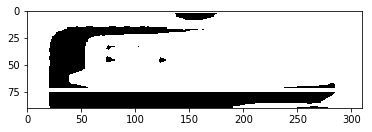

i am not saving


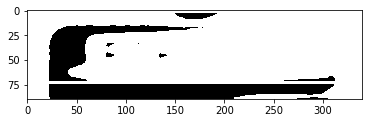

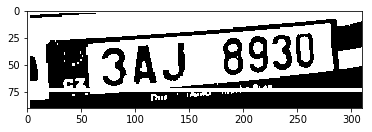

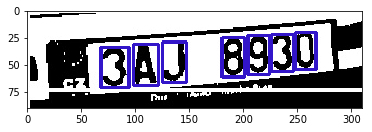

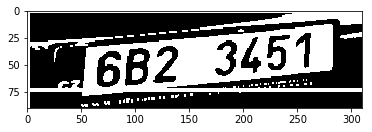

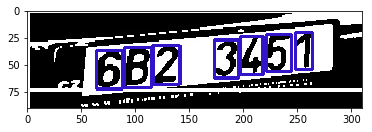

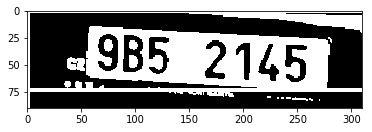

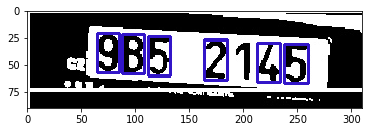

i am not saving


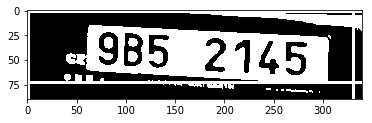

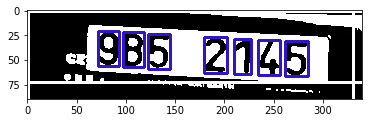

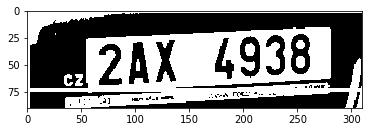

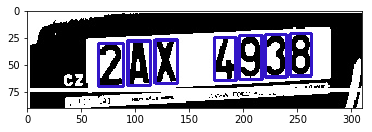

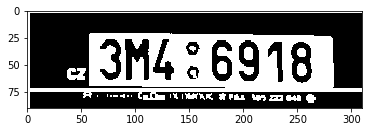

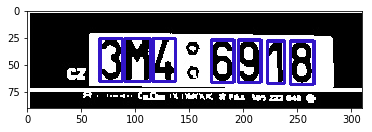

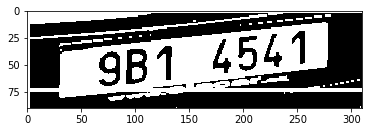

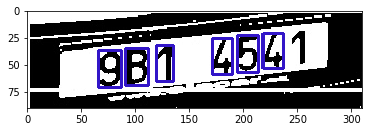

i am not saving


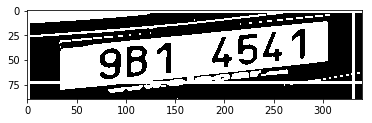

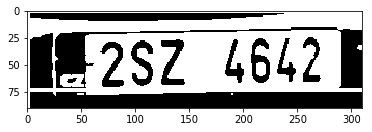

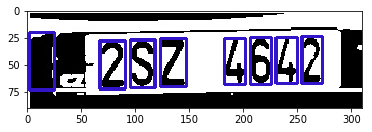

i am not saving


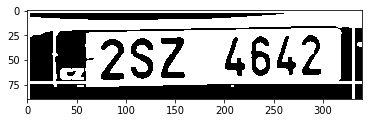

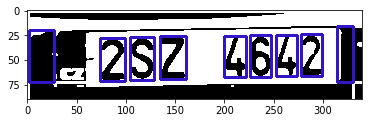

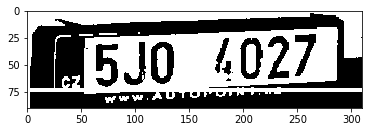

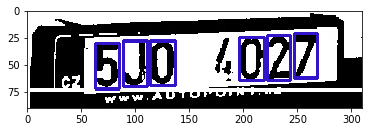

i am not saving


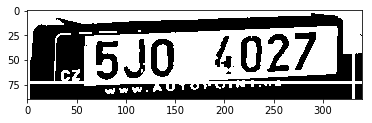

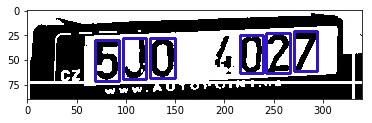

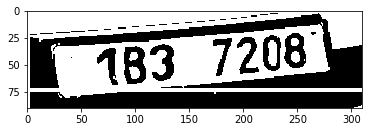

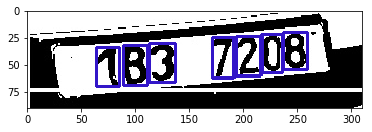

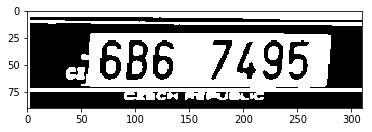

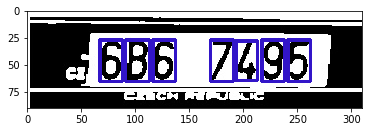

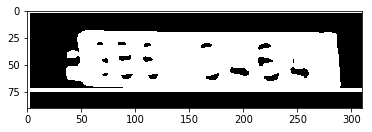

i am not saving


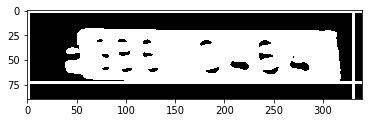

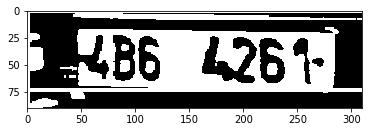

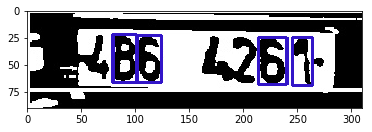

i am not saving


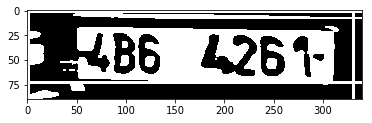

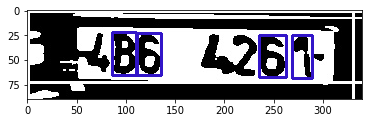

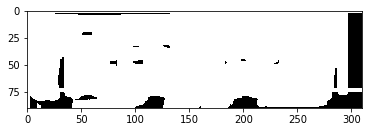

i am not saving


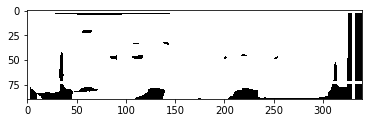

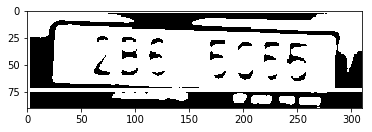

i am not saving


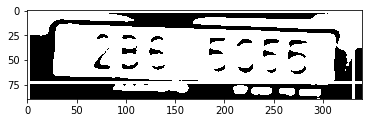

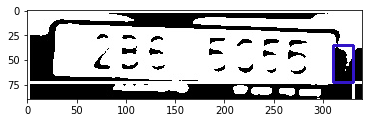

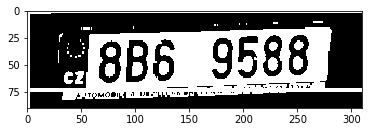

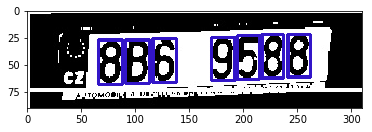

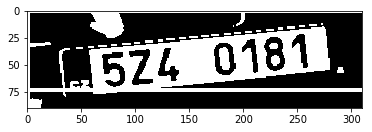

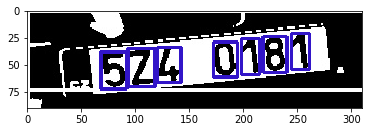

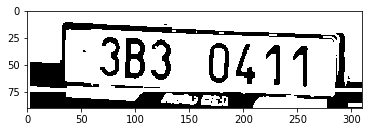

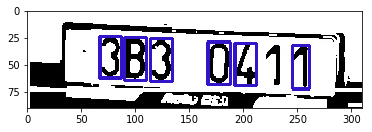

i am not saving


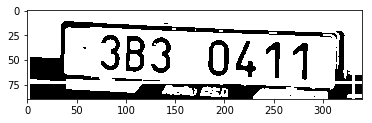

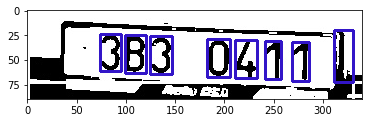

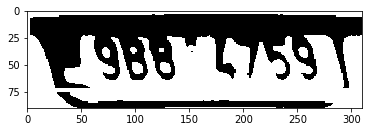

i am not saving


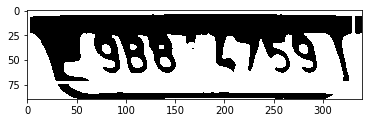

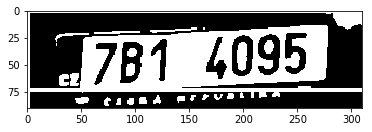

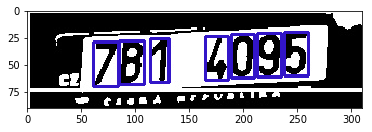

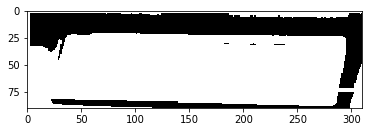

i am not saving


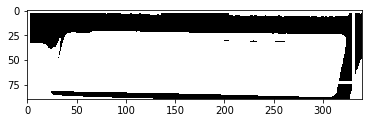

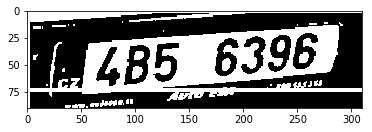

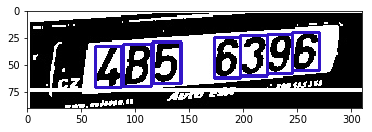

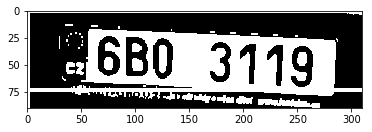

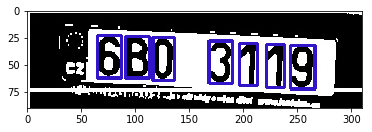

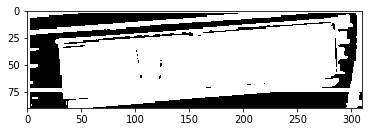

i am not saving


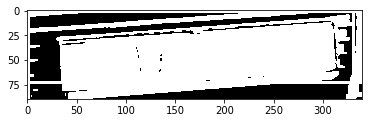

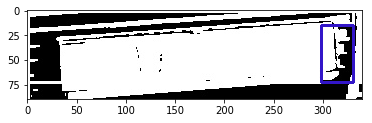

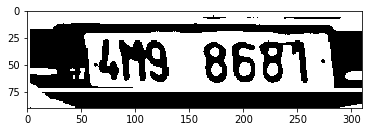

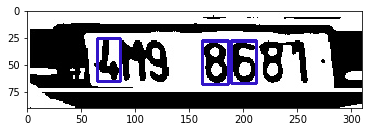

i am not saving


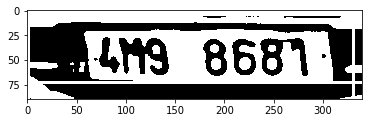

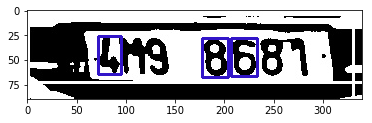

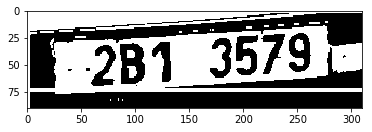

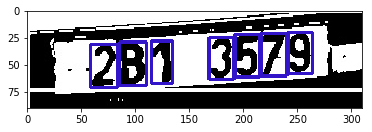

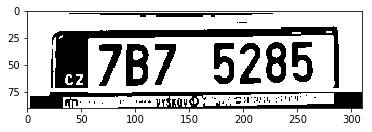

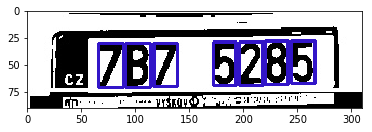

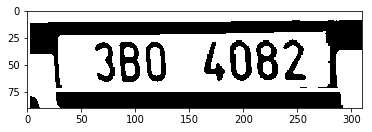

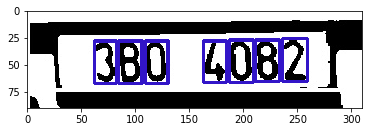

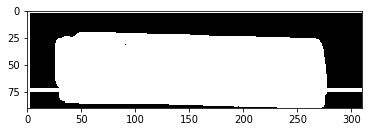

i am not saving


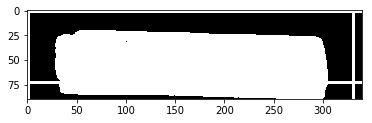

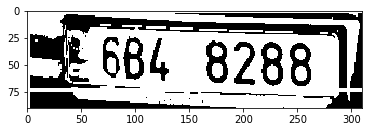

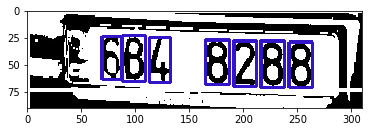

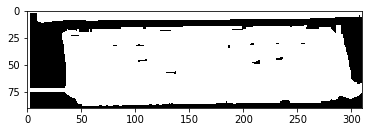

i am not saving


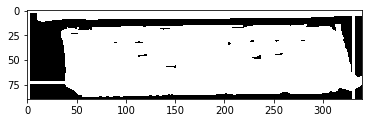

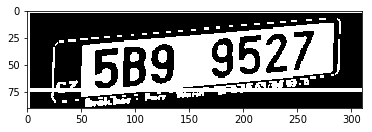

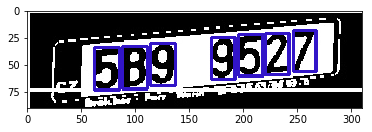

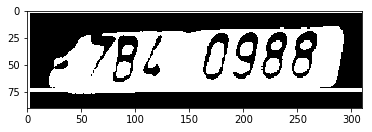

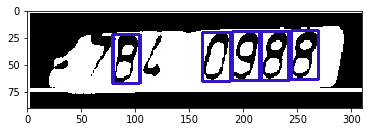

i am not saving


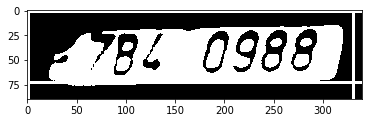

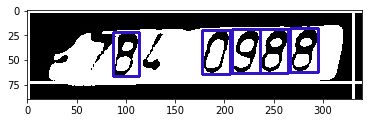

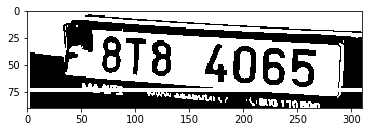

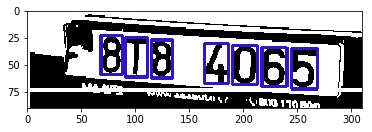

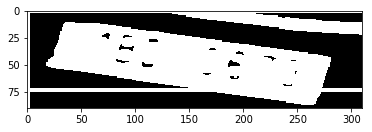

i am not saving


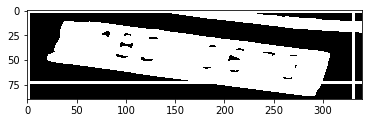

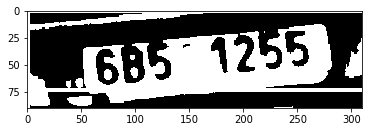

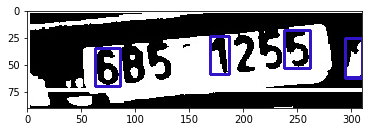

i am not saving


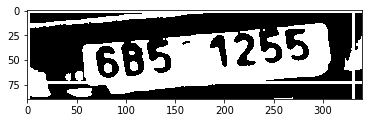

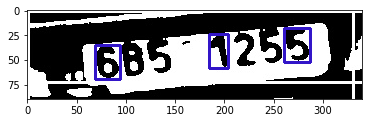

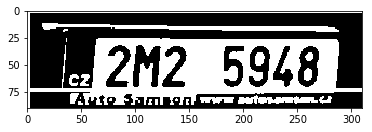

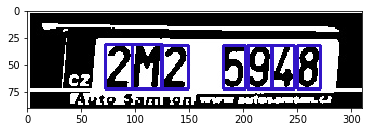

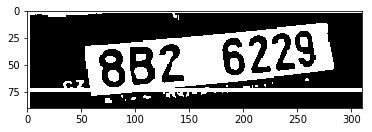

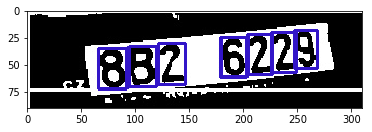

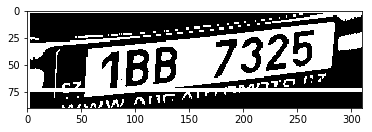

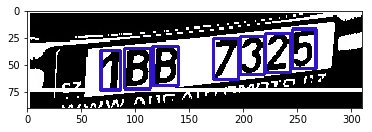

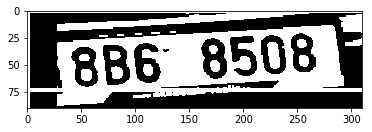

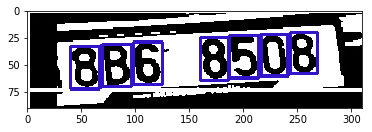

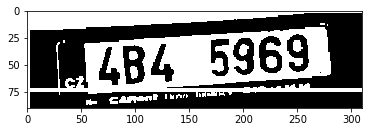

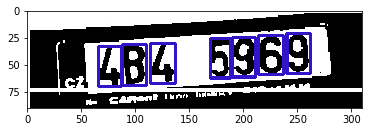

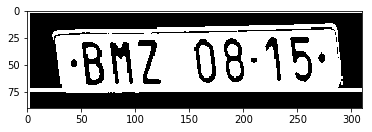

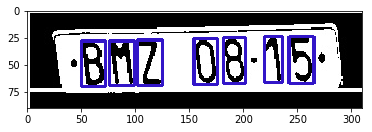

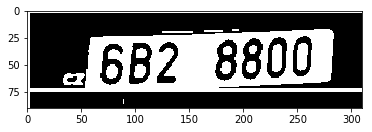

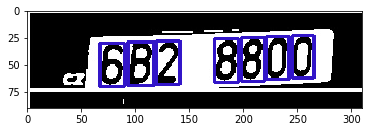

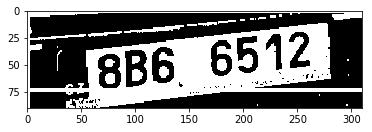

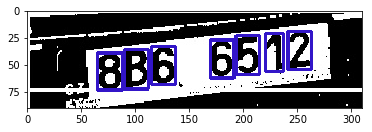

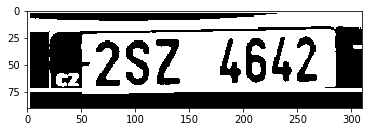

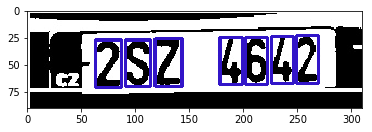

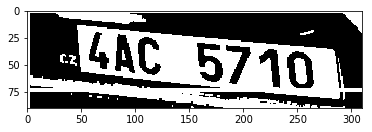

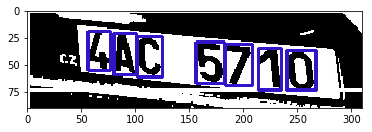

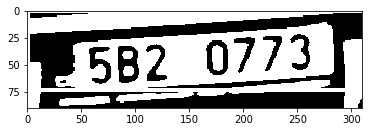

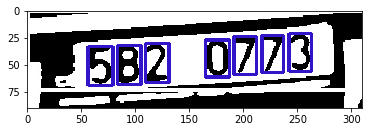

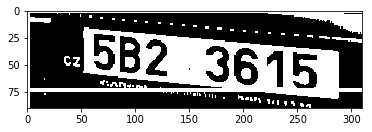

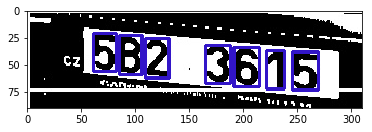

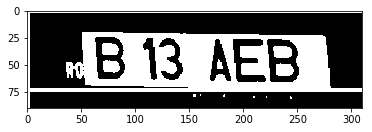

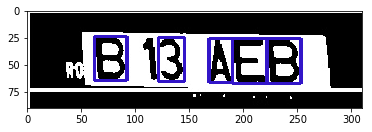

i am not saving


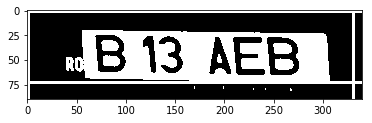

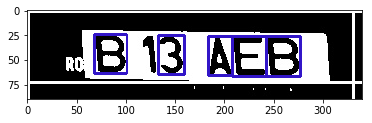

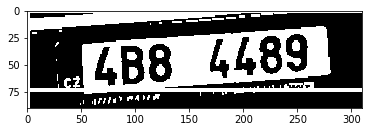

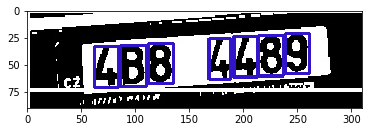

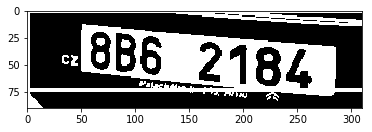

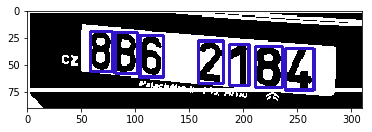

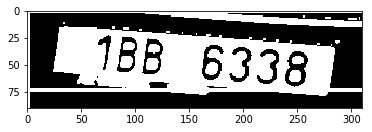

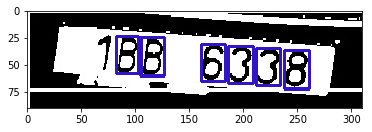

i am not saving


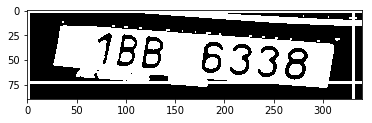

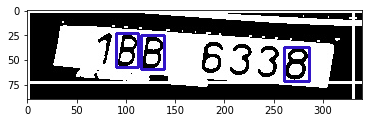

In [29]:
test_df["predicted_number"] = test_df.apply(predict_results,axis=1)

In [37]:
test_df[test_df["predicted_number"] == "Distorted_image"].to_csv("distorted_images.csv")

In [38]:
test_df[test_df["predicted_number"] == "Distorted_image"].shape

(42, 6)

In [35]:
test_df_without_distorted = test_df[test_df["predicted_number"] != "Distorted_image"]

In [42]:
def is_equal(df):
    return str(df["lp"])==str(df["predicted_number"])
        

In [44]:
test_df_without_distorted["correctness"] = test_df_without_distorted.apply(is_equal,axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
test_df_without_distorted.shape

(89, 7)

In [57]:
test_df_without_distorted.to_csv("total_prediction.csv")

In [47]:
test_df_without_distorted[test_df_without_distorted["correctness"] == True].shape

(86, 7)

In [56]:
test_df_without_distorted[test_df_without_distorted["correctness"] == True].to_csv("True_prediction.csv")